In [14]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from gpp.world_models_vae import ConvVAE

os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # can just override for multi-gpu systems
np.set_printoptions(precision=4, edgeitems=6, linewidth=100, suppress=True)

data_path = "data"
dataset = np.load(os.path.join(data_path, 'push_sphere_v0_imgs.npz'))
dataset = dataset['arr_0']
dataset = dataset / 255.
new_data = []
for i, d in enumerate(dataset):
    new_data.append(cv2.resize(d, (64, 64), interpolation=cv2.INTER_AREA))
dataset = np.array(new_data)
print("Data loaded")

z_size = 16
batch_size = 32
kl_tolerance = 0.5
learning_rate = 0.001
vae = ConvVAE(z_size=z_size, batch_size=batch_size, learning_rate=learning_rate, kl_tolerance=kl_tolerance,
              is_training=True, reuse=False, gpu_mode=False, reconstruction_option=1,
              kl_option=2)
vae.load_json("scripts/best_models/superModels/kl2rl1-z16-b250-push_sphere_v0vae-fetch199.json")
print("Model loaded")



Data loaded
INFO:tensorflow:Model using cpu.


Model loaded


In [15]:
latent_walk_length = 32
alive_threshold = 0.05
reconstructed_imgs = []
alive_idx_set = []
mean_variances = np.zeros(z_size)
for pic_index in range(10):
    z = vae.encode(dataset[:batch_size])
    mins = np.min(z, axis=0)
    maxes = np.max(z, axis=0)
    originals = z[pic_index].copy()
    reconstructed_imgs = []
    for i in range(z.shape[1]):
        latent_walk = np.linspace(mins[i], maxes[i], latent_walk_length)
        latent_walk_imgs = []
        for j, walk in enumerate(latent_walk):
            z[pic_index][i] = walk
            latent_walk_imgs.append(z[pic_index].copy())
        latent_walk_imgs = np.array(latent_walk_imgs)
        reconstruct = vae.decode(latent_walk_imgs)
        reconstructed_imgs.append(reconstruct.copy())
        z[pic_index] = originals        
    results = []
    for img in reconstructed_imgs:
        var = np.var(img, axis=0)
        results.append(var.max())
    mean_variances += np.array(results)    
    alive_idx = np.where(np.array(results) > alive_threshold)
    alive_idx_set.extend(list(alive_idx[0]))
    # print("Alive indixes for image: {}\n{}".format(pic_index, alive_idx))
mean_variances /= latent_walk_length
alive_idx_set = list(set(alive_idx_set))
print(alive_idx_set)
print(len(alive_idx_set))


[0, 1, 2, 3, 4, 6, 7, 8, 10, 11, 12, 13, 14, 15]


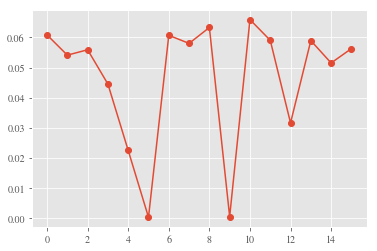

In [16]:
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
# plt.rcParams['savefig.dpi'] = 250
plt.style.use('ggplot')
plt.rcParams["errorbar.capsize"] = 2
plt.plot(mean_variances, '-o')

Number of alive indices: 14


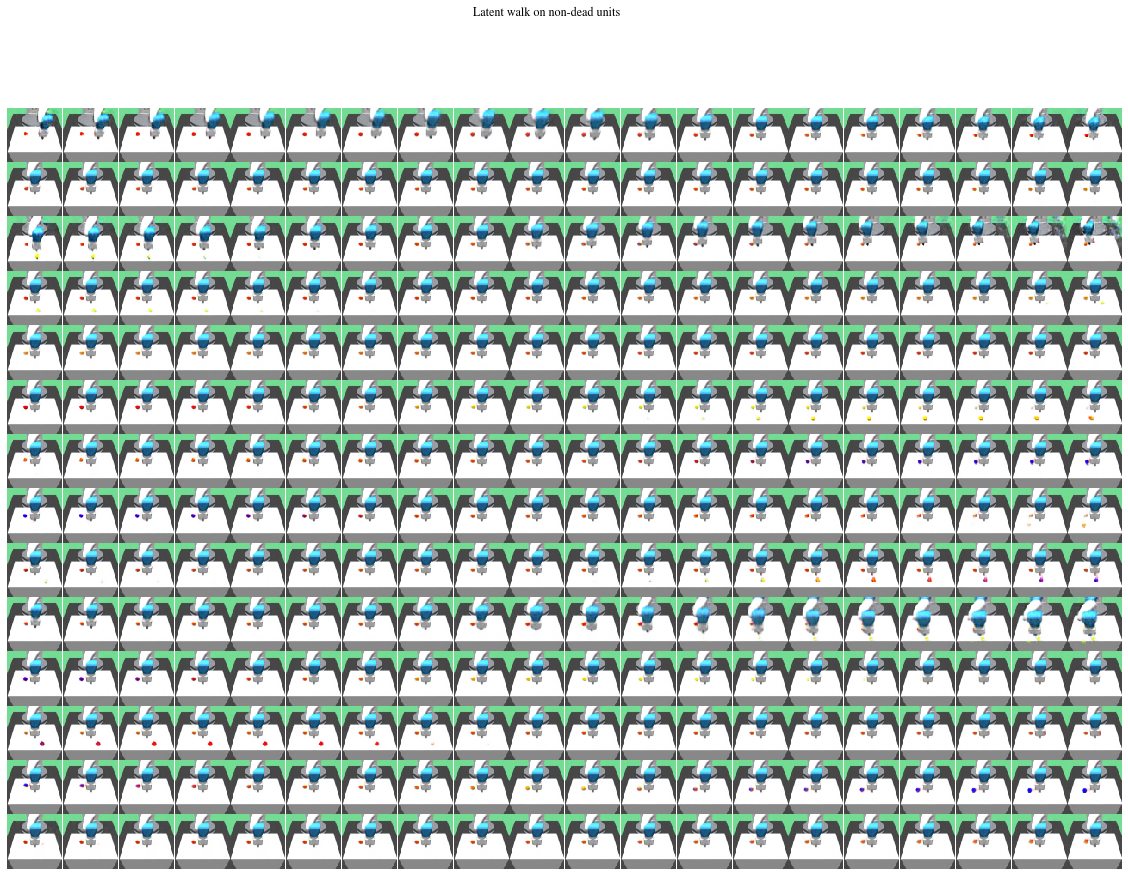

In [26]:
from tqdm import tqdm_notebook as tqdm
import matplotlib.gridspec as gridspec
print("Number of alive indices: {}".format(len(alive_idx_set)))
pic_index = 0
z = vae.encode(dataset[110: 110+batch_size])
reconstruct = vae.decode(z)
pic = reconstruct[pic_index]
mins = np.min(z, axis=0)
maxes = np.max(z, axis=0)
originals = z[pic_index].copy()
latent_walk_length = 20
fig = plt.figure(figsize=(latent_walk_length, len(alive_idx_set)))
plt.tight_layout()

fig.suptitle("Latent walk on non-dead units")
for idx, i in tqdm(enumerate(alive_idx_set)):
    latent_walk = np.linspace(mins[i]-1, maxes[i]+1, latent_walk_length)
    for j, walk in enumerate(latent_walk):
        z[pic_index][i] = walk
        reconstruct = vae.decode(z)
        ax1 = plt.subplot(len(alive_idx_set), latent_walk_length, (idx * latent_walk_length + (j + 1)))
        plt.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        plt.imshow(reconstruct[pic_index])
        z[pic_index] = originals
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig("disentaglement_check.pdf", format="pdf")


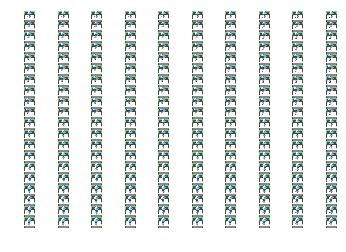

<Figure size 432x288 with 0 Axes>

In [57]:
latent_index_of_interrest = alive_idx_set[-2]
z = vae.encode(dataset[110: 110+batch_size])
reconstruct = vae.decode(z)
pic = reconstruct[pic_index]
mins = np.min(z, axis=0)
maxes = np.max(z, axis=0)

latent_walk_length = 10
latent_walk = np.linspace(mins[latent_index_of_interrest]-1, maxes[latent_index_of_interrest]+1, latent_walk_length)
fig = plt.figure()
plt.tight_layout()
pic_index = 0
n_pics = 20
for pic_index in range(n_pics):
    originals = z[pic_index].copy()
    for j, walk in enumerate(latent_walk):
        z[pic_index][latent_index_of_interrest] = walk
        reconstruct = vae.decode(z)
        a = fig.add_subplot(n_pics, latent_walk_length, (pic_index * latent_walk_length + (j + 1)))
        plt.imshow(reconstruct[pic_index])
        plt.axis('off')
        z[pic_index] = originals
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(f"disentaglement_color_{pic_index}.pdf", format="pdf")
plt.show()
plt.cla()
plt.clf()


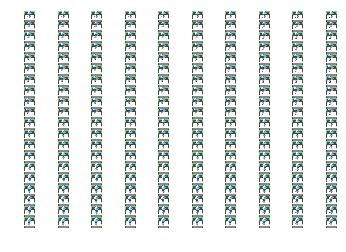

<Figure size 432x288 with 0 Axes>

In [54]:
plt.cla()
plt.clf()

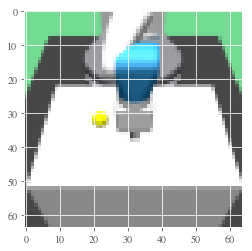

In [24]:
# for i in range(300):
#     plt.grid("off")
#     plt.title(str(i))
#     plt.imshow(dataset[i])
#     plt.show()
plt.imshow(dataset[110])  # only yellow ball 
# plt.imshow(dataset[103])  # only blue ball
